=== demo Game ===

=== round 1 ===
dealer bets 10 chips
Player, you have 1000 chips, how much do you like to bet? 60
Player bets 60 chips

initial hands:
dealer: [4♠, ?]
Player: [10♥, 7♠] (Value: 17)

Player's turn:

your hand: [10♥, 7♠] (Value: 17)
dealer's up card: 4♠
do you like to (h)it or (s)tand? s
Player wants to stand

dealer's turn:
this is dealer's hand: [4♠] (Value: 4)
dealer is draws A♦. the new hand gonna be: [4♠, A♦] (Value: 15)
dealer is draws 10♠. the new hand gonna be: [4♠, A♦, 10♠] (Value: 15)
dealer is draws 5♣. the new hand gonna be: [4♠, A♦, 10♠, 5♣] (Value: 20)
Player loses 60 chips (low value)

round summary:
dealer: 990 chips
Player: 880 chips

Threshold: -2
avg winnings per round: -6.78
std deviation: 92.27
prob of net winning: 0.0%
prob of net losing: 100.0%


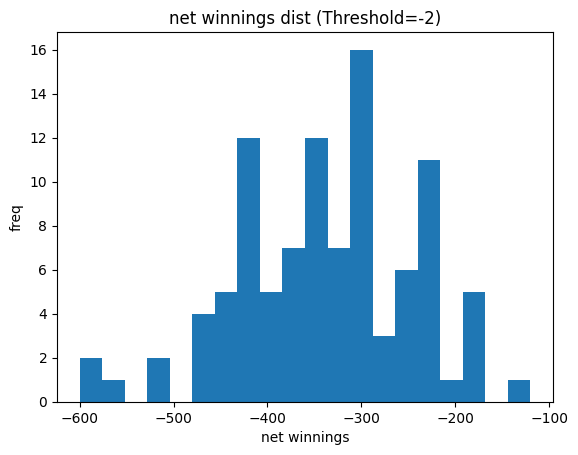


Threshold: -1
avg winnings per round: -6.06
std deviation: 91.28
prob of net winning: 0.0%
prob of net losing: 100.0%


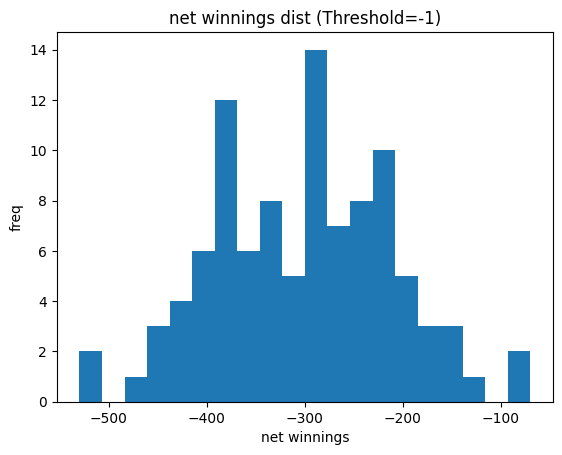


Threshold: 0
avg winnings per round: -5.47
std deviation: 90.08
prob of net winning: 0.0%
prob of net losing: 100.0%


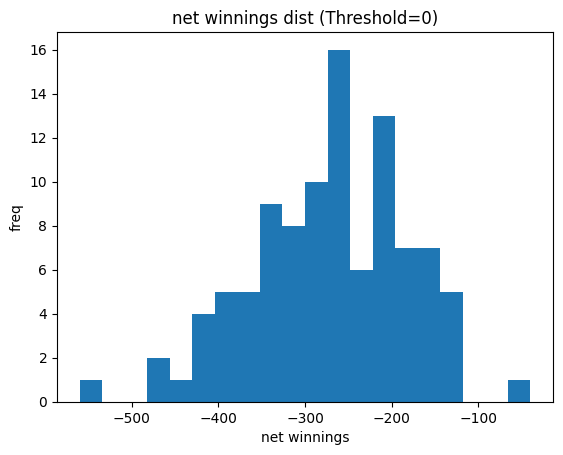


Threshold: 1
avg winnings per round: -5.95
std deviation: 94.90
prob of net winning: 0.0%
prob of net losing: 100.0%


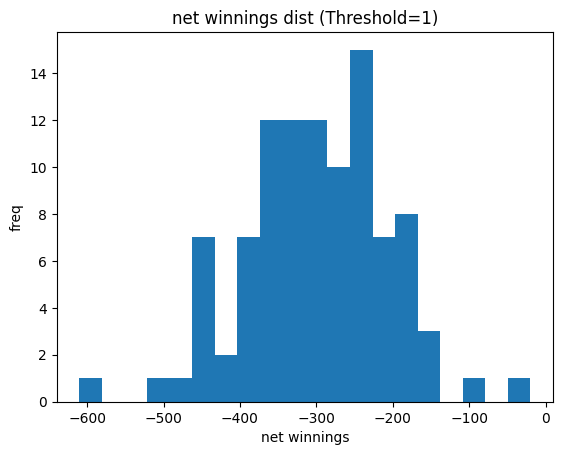


Threshold: 2
avg winnings per round: -5.76
std deviation: 98.92
prob of net winning: 0.0%
prob of net losing: 100.0%


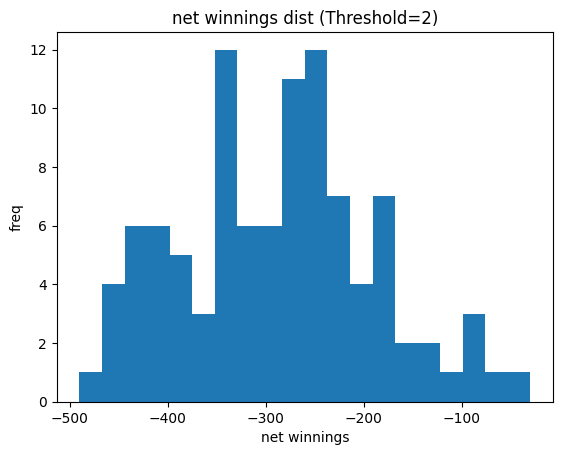

In [3]:
import random
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np

class Card:
    def __init__(self, suit, rank):
        self.suit = suit
        self.rank = rank
        self.value = self._determine_value()

    def _determine_value(self):
        if self.rank in ['J', 'Q', 'K']:
            return 10
        elif self.rank == 'A':
            return 11
        else:
            return int(self.rank)

    def __str__(self):
        return f"{self.rank}{self.suit}"

    def __repr__(self):
        return self.__str__()

class Deck:
    def __init__(self, num_decks=6):
        self.num_decks = num_decks
        self.cards = []
        self.reshuffle()

    def reshuffle(self):
        suits = ['♠', '♥', '♦', '♣']
        ranks = ['2', '3', '4', '5', '6', '7', '8', '9', '10', 'J', 'Q', 'K', 'A']

        self.cards = []
        for _ in range(self.num_decks):
            for suit in suits:
                for rank in ranks:
                    self.cards.append(Card(suit, rank))

        plastic_pos = random.randint(int(0.6*len(self.cards)), int(0.75*len(self.cards)))
        self.plastic_pos = plastic_pos
        random.shuffle(self.cards)

    def draw(self):
        if not self.cards:
            self.reshuffle()
            return self.draw()

        card = self.cards.pop()

        if len(self.cards) <= self.plastic_pos:
            self.reshuffle()

        return card

    def needs_shuffle(self):
        return len(self.cards) < 20

class Hand:
    def __init__(self, bet=0):
        self.cards = []
        self.bet = bet

    def add_card(self, card):
        self.cards.append(card)

    def get_value(self):
        value = 0
        aces = 0

        for card in self.cards:
            value += card.value
            if card.rank == 'A':
                aces += 1


        while value > 21 and aces:
            value -= 10
            aces -= 1

        return value

    def is_blackjack(self):
        return len(self.cards) == 2 and self.get_value() == 21

    def is_busted(self):
        return self.get_value() > 21

    def __str__(self):
        return f"{self.cards} (Value: {self.get_value()})"

class Player:
    def __init__(self, name, chips=1000):
        self.name = name
        self.chips = chips
        self.hands = []
        self.current_hand_index = 0

    def place_bet(self, amount):
        if amount > self.chips:
            raise ValueError("chips are lacking")
        self.chips -= amount
        return amount

    def decide_action(self, hand, dealer_up_card, game_state):
        raise NotImplementedError("subclass need method")

    def receive_card(self, card, hand_index=0):
        if hand_index >= len(self.hands):
            self.hands.append(Hand())
        self.hands[hand_index].add_card(card)

    def win(self, amount, hand_index=0):
        self.chips += amount
        return amount

    def lose(self, amount, hand_index=0):
        self.chips -= amount
        return amount

    def __str__(self):
        return f"{self.name} (chips: {self.chips})"

class DealerPlayer(Player):
    def decide_action(self, hand, dealer_up_card, game_state):
        if hand.get_value() < 17:
            return 'hit'
        elif hand.get_value() == 17 and any(card.rank == 'A' for card in hand.cards):
            return 'hit'
        else:
            return 'stand'

class HumanPlayer(Player):
    def make_bet(self):
        while True:
            try:
                bet = int(input(f"{self.name}, you have {self.chips} chips, how much do you like to bet? "))
                if 0 < bet <= self.chips:
                    return self.place_bet(bet)
                print("invalid bet amount.  try again.")
            except ValueError:
                print(" enter a valid number.")

    def decide_action(self, hand, dealer_up_card, game_state):
        print(f"\nyour hand: {hand}")
        print(f"dealer's up card: {dealer_up_card}")

        while True:
            action = input("do you like to (h)it or (s)tand? ").lower()
            if action in ['h', 'hit']:
                return 'hit'
            elif action in ['s', 'stand']:
                return 'stand'
            print("wrong input.  enter 'h' or 's'.")

class CountPlayer(Player):
    def __init__(self, name, chips=1000, threshold=0):
        super().__init__(name, chips)
        self.count = 0
        self.threshold = threshold
        self.card_values = {
            '2': 1, '3': 1, '4': 1, '5': 1, '6': 1,
            '7': 0, '8': 0, '9': 0,
            '10': -1, 'J': -1, 'Q': -1, 'K': -1, 'A': -1
        }

    def update_count(self, card):
        self.count += self.card_values.get(card.rank, 0)

    def decide_action(self, hand, dealer_up_card, game_state):
        value = hand.get_value()
        adjusted_value = value - (self.count / 10)

        if adjusted_value < 12 + self.threshold:
            return 'hit'
        else:
            return 'stand'

class Game:
    def __init__(self, players, num_decks=6, verbose=False):
        self.deck = Deck(num_decks)
        self.players = players
        self.round = 0
        self.verbose = verbose

    def play_round(self):
        self.round += 1
        if self.verbose:
            print(f"\n=== round {self.round} ===")

        for player in self.players:
            player.hands = [Hand()]

        bets = {}
        for player in self.players:
            if isinstance(player, HumanPlayer):
                bet = player.make_bet()
            else:
                bet = player.place_bet(10)
            player.hands[0].bet = bet
            bets[player] = bet
            if self.verbose:
                print(f"{player.name} bets {bet} chips")

        dealer = self.players[0]
        for _ in range(2):
            for player in self.players:
                if player == dealer and _ == 1:
                    continue
                card = self.deck.draw()
                player.receive_card(card)
                if player != dealer and isinstance(player, CountPlayer):
                    player.update_count(card)

        if self.verbose:
            print("\ninitial hands:")
            for player in self.players:
                if player == dealer:
                    print(f"{player.name}: [{player.hands[0].cards[0]}, ?]")
                else:
                    print(f"{player.name}: {player.hands[0]}")

        for player in self.players[1:]:
            if self.verbose:
                print(f"\n{player.name}'s turn:")

            for i, hand in enumerate(player.hands):
                while not hand.is_busted():
                    action = player.decide_action(hand, dealer.hands[0].cards[0], self)
                    if self.verbose:
                        print(f"{player.name} wants to {action}")

                    if action == 'stand':
                        break

                    card = self.deck.draw()
                    hand.add_card(card)
                    if isinstance(player, CountPlayer):
                        player.update_count(card)
                    if self.verbose:
                        print(f"{player.name} draws {card}. New hand: {hand}")

                    if hand.is_busted():
                        if self.verbose:
                            print(f"{player.name} busts OH NO LOL")
                        break

        dealer_hand = dealer.hands[0]
        if self.verbose:
            print(f"\n{dealer.name}'s turn:")
            print(f"this is dealer's hand: {dealer_hand}")

        while not dealer_hand.is_busted():
            action = dealer.decide_action(dealer_hand, None, self)
            if action == 'stand':
                break

            card = self.deck.draw()
            dealer_hand.add_card(card)
            if self.verbose:
                print(f"dealer is draws {card}. the new hand gonna be: {dealer_hand}")

            if dealer_hand.is_busted():
                if self.verbose:
                    print("dealer BUSTSSSS!")
                break

        dealer_value = dealer_hand.get_value() if not dealer_hand.is_busted() else 0

        for player in self.players[1:]:
            for i, hand in enumerate(player.hands):
                if hand.is_busted():
                    player.lose(hand.bet, i)
                    if self.verbose:
                        print(f"{player.name} loses {hand.bet} chips (busted)")
                else:
                    player_value = hand.get_value()

                    if dealer_hand.is_busted():
                        winnings = hand.bet * 2
                        player.win(winnings, i)
                        if self.verbose:
                            print(f"{player.name} wins {winnings} chips (dealer busted)")
                    else:
                        if player_value > dealer_value:
                            winnings = hand.bet * 2
                            player.win(winnings, i)
                            if self.verbose:
                                print(f"{player.name} wins {winnings} chips (higher value)")
                        elif player_value == dealer_value:
                            player.win(hand.bet, i)
                            if self.verbose:
                                print(f"{player.name} pushes (IDENTICAL value)")
                        else:
                            player.lose(hand.bet, i)
                            if self.verbose:
                                print(f"{player.name} loses {hand.bet} chips (low value)")


        if self.verbose:
            print("\nround summary:")
            for player in self.players:
                print(f"{player.name}: {player.chips} chips")

    def play_game(self, num_rounds=50):
        for _ in range(num_rounds):
            active_players = [p for p in self.players if p.chips > 0]
            if len(active_players) <= 1:
                break

            self.play_round()

            if self.deck.needs_shuffle():
                self.deck.reshuffle()
                for player in self.players:
                    if isinstance(player, CountPlayer):
                        player.count = 0

        if self.verbose:
            print("\nfinal chip counts:")
            for player in self.players:
                print(f"{player.name}: {player.chips} chips")

        return {player.name: player.chips for player in self.players}

def simulate_games(num_games=100, num_rounds=50, threshold=0):
    results = []

    for _ in range(num_games):
        dealer = DealerPlayer("dealer")
        strategy_player = CountPlayer("Strategy", 1000, threshold)
        basic_players = [DealerPlayer(f"basic plain{i}") for i in range(3)]

        players = [dealer] + basic_players + [strategy_player]

        game = Game(players, verbose=False)
        final_chips = game.play_game(num_rounds)

        results.append(final_chips["Strategy"] - 1000)

    return results

def analyze_results(results, threshold):
    avg = np.mean(results)
    std = np.std(results)
    win_prob = sum(1 for x in results if x > 0) / len(results)
    loss_prob = sum(1 for x in results if x < 0) / len(results)

    print(f"\nThreshold: {threshold}")
    print(f"avg winnings per round: {avg/50:.2f}")
    print(f"std deviation: {std:.2f}")
    print(f"prob of net winning: {win_prob*100:.1f}%")
    print(f"prob of net losing: {loss_prob*100:.1f}%")

    plt.hist(results, bins=20)
    plt.title(f"net winnings dist (Threshold={threshold})")
    plt.xlabel("net winnings")
    plt.ylabel("freq")
    plt.show()

def main():
    print("=== demo Game ===")
    dealer = DealerPlayer("dealer")
    human = HumanPlayer("Player")
    game = Game([dealer, human], verbose=True)
    game.play_round()

    thresholds = [-2, -1, 0, 1, 2]

    for threshold in thresholds:
        results = simulate_games(threshold=threshold)
        analyze_results(results, threshold)

if __name__ == "__main__":
    main()